In [1]:
import os
import re
import nibabel as nib
import numpy as np
import h5py

import matplotlib.pyplot as plt
from scipy import stats

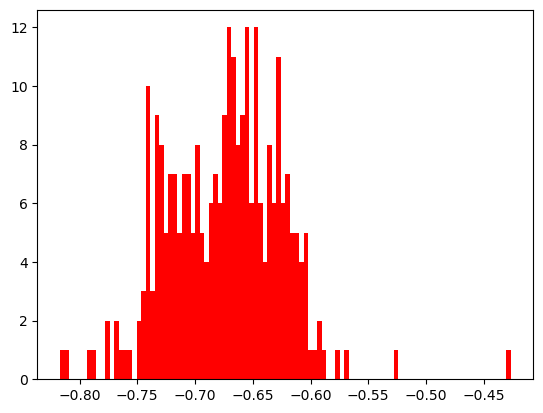

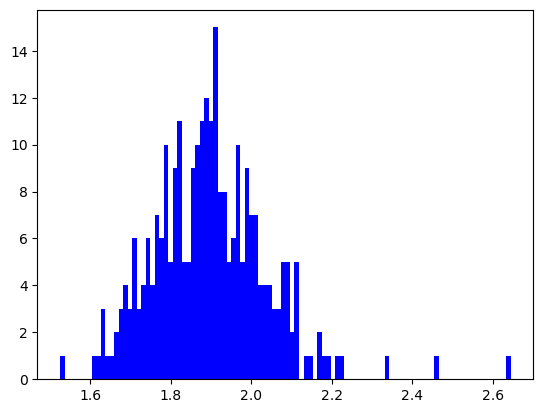

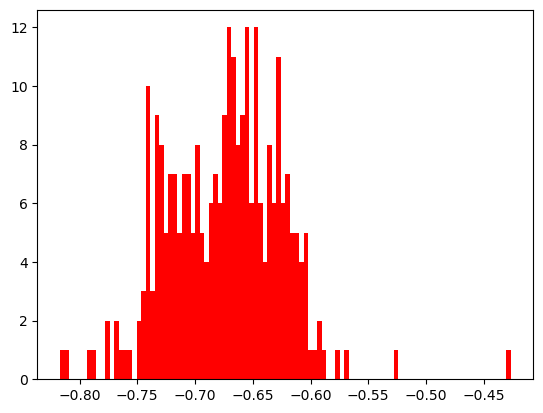

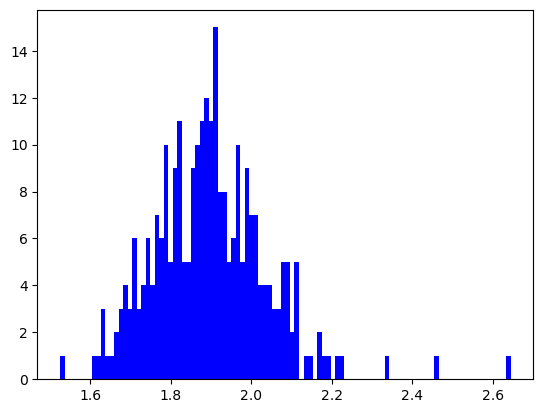

In [10]:
# Preprocess the data

# Min-Max normalization
# loop through all data and find the min and max
min_val = 100000
max_val = 0
all_min = []
all_max = []
percentile_1 = []
percentile_99 = []
directory = 'train'
for root, dirs, files in os.walk(directory):
        dirs.sort() # Sort directories in ascending order
        for file in files:
            if file.endswith('.nii.gz'):
                if "t1ce" in file:
                    img = nib.load(os.path.join(root, file)).get_fdata()
                    # flip the image
                    img = np.flip(img, axis=1)
                    # crop the image
                    img = img[48:192, 16:208,:]
                    # add zero padding
                    img = np.pad(img, ((0,0),(0,0),(5,0)), 'constant')
                    # z norm - local
                    img = (img - np.mean(img)) / np.std(img)
                    # calculate the percentiles
                    p1 = np.percentile(img, 2.5)
                    p99 = np.percentile(img, 97.5)
                    percentile_1.append(p1)
                    percentile_99.append(p99)
                    # perform clipping
                    img = np.clip(img, p1, p99)
                    all_min.append(np.min(img))                    
                    all_max.append(np.max(img))  
                    # plt.hist(img.flatten(), bins=100, color='b')
                    # plt.show()                  
                    # min max normalisation
                    # img = (img - (-0.816889567388382)) / (14.109526984530119 - (-0.816889567388382))
                    # print(np.mean(img))
                    # print(np.std(img))
                    # print("min: ", np.min(img))
                    # print("max: ", np.max(img))
                    # break

# plot histogram of percentiles
plt.hist(percentile_1, bins=100, color='r')
plt.show()
plt.hist(percentile_99, bins=100, color='b')
plt.show()
# plot histogram of min and max values
plt.hist(all_min, bins=100, color='r')
plt.show()
plt.hist(all_max, bins=100, color='b')
plt.show()
# print("Mode:", stats.mode(all_max)[0][0])

# directory = 'val'
# for root, dirs, files in os.walk(directory):
#         dirs.sort() # Sort directories in ascending order
#         for file in files:
#             if file.endswith('.nii.gz'):
#                 if "t1ce" in file:
#                     img = nib.load(os.path.join(root, file)).get_fdata()
#                                         # crop the image
#                     img = img[48:192, 32:224,:]
#                     # add zero padding
#                     img = np.pad(img, ((0,0),(0,0),(5,0)), 'constant')
#                     # # z normalisation
#                     # print(np.mean(img))
#                     # print(np.std(img))
#                     img = (img - np.mean(img)) / np.std(img)
#                     # min max normalisation
#                     img = (img - (-0.816889567388382)) / (14.109526984530119 - (-0.816889567388382))
#                     min_val = min(min_val, np.min(img))
#                     max_val = max(max_val, np.max(img))

# print("Min: ", min_val)
# print("Max: ", max_val)

In [2]:
def make_groups(hdf5_file):
    with h5py.File(hdf5_file, 'a') as f:
        training = f.create_group('training')
        validation = f.create_group('validation')
        test = f.create_group('test')

        training_base = training.create_group('base')
        training_follow = training.create_group('follow')

        validation_base = validation.create_group('base')
        validation_follow = validation.create_group('follow')

        test_base = test.create_group('base')
        test_follow = test.create_group('follow')

        training_base_t1ce = training_base.create_group('t1ce')
        training_base_landmarks = training_base.create_group('landmarks')

        training_follow_t1ce = training_follow.create_group('t1ce')
        training_follow_landmarks = training_follow.create_group('landmarks')

        validation_base_t1ce = validation_base.create_group('t1ce')
        validation_base_landmarks = validation_base.create_group('landmarks')

        validation_follow_t1ce = validation_follow.create_group('t1ce')
        validation_follow_landmarks = validation_follow.create_group('landmarks')

        test_base_t1ce = test_base.create_group('t1ce')
        test_base_landmarks = test_base.create_group('landmarks')

        test_follow_t1ce = test_follow.create_group('t1ce')
        test_follow_landmarks = test_follow.create_group('landmarks')


In [3]:
def crop_invert_normalize(img):
    # invert the image on the y-axis
    img = np.flip(img, axis=1)
    # crop the image
    # img = img[48:192, 32:224,:] # that's the crop from NiceNet, but we invert, so have to change the y-crop
    # old crop: 32 left and 240-224=16 right
    # new crop: 16 left and 240-208=32 right
    img = img[48:192, 16:208,:]
    # add zero padding
    img = np.pad(img, ((0,0),(0,0),(5,0)), 'constant')
    # z norm - local
    img = (img - np.mean(img)) / np.std(img)
    # clipping to 2.5 and 97.5 percentile
    # p1 = np.percentile(img, 2.5)
    # p99 = np.percentile(img, 97.5)
    img = np.clip(img, -6, 6)
    # min-max normalization - local
    mymin = np.min(img)
    mymax = np.max(img)
    img = (img - mymin) / (mymax - mymin)
    return img

# OLD:
# def crop_invert_normalize(img, mymin, mymax):
#     # invert the image on the y-axis
#     img = np.flip(img, axis=1)
#     # crop the image
#     # img = img[48:192, 32:224,:] # that's the crop from NiceNet, but we invert, so have to change the y-crop
#     # old crop: 32 left and 240-224=16 right
#     # new crop: 16 left and 240-208=32 right
#     img = img[48:192, 16:208,:]
#     # add zero padding
#     img = np.pad(img, ((0,0),(0,0),(5,0)), 'constant')
#     # z norm - local
#     img = (img - np.mean(img)) / np.std(img)
#     # min-max normalization - global
#     img = (img - mymin) / (mymax - mymin)
#     return img

def adjust_landmarks(landmarks):
    # invert the landmarks on the y-axis
    landmarks[:,1] = landmarks[:,1] * -1
    # apply the crop and padding
    landmarks[:,0] = landmarks[:,0] - 48
    landmarks[:,1] = landmarks[:,1] - 16
    landmarks[:,2] = landmarks[:,2] + 5
    return landmarks

def process_directory(directory, hdf5_file):
    test_size = 20

    # # Find min and max of t1ce images
    # # OLD: Minimum and Maximum values of the training set after z-normalization
    # min_t1ce = -0.816889567388382
    # max_t1ce = 14.109526984530119
    i = 0
    for root, dirs, files in os.walk(directory):
        dirs.sort() # Sort directories in ascending order
        k = i
        if directory == "train":
            if i < test_size:
                group = "test"
            else:
                group = "training"
                k = i - test_size
        elif directory == "val":
            group = "validation"
        for file in files:
            if file.endswith('.nii.gz'):
                if "00_0000_t1ce" in file:
                    img = nib.load(os.path.join(root, file)).get_fdata()
                    # my preprocessing
                    img = crop_invert_normalize(img)
                    with h5py.File(hdf5_file, 'a') as f:
                        f[group+'/base/t1ce'].create_dataset(str(k), data=img)

                if re.search('01_\d+_t1ce', file):
                    img = nib.load(os.path.join(root, file)).get_fdata()
                    # my preprocessing
                    img = crop_invert_normalize(img)
                    with h5py.File(hdf5_file, 'a') as f:
                        f[group+'/follow/t1ce'].create_dataset(str(k), data=img)
                        
            elif file.endswith('.csv'):
                if "00_0000_landmarks" in file:
                    landmarks = np.genfromtxt(os.path.join(root, file), delimiter=',')[1:, 1:]
                    # my preprocessing
                    landmarks = adjust_landmarks(landmarks)
                    with h5py.File(hdf5_file, 'a') as f:
                        f[group+'/base/landmarks'].create_dataset(str(k), data=landmarks)
                if re.search('01_\d+_landmarks', file):
                    # Read CSV file
                    landmarks = np.genfromtxt(os.path.join(root, file), delimiter=',')[1:, 1:]
                    # my preprocessing
                    landmarks = adjust_landmarks(landmarks)
                    with h5py.File(hdf5_file, 'a') as f:
                        f[group+'/follow/landmarks'].create_dataset(str(k), data=landmarks)
                        
        if "BraTSReg" in root:
            i+= 1

    with h5py.File(hdf5_file, 'a') as f:
    # Add dataset size as attribute to HDF5 file
        if directory == "train":
            f['training'].attrs['N'] = i - test_size
            f['test'].attrs['N'] = test_size
        elif directory == "val":
            f['validation'].attrs['N'] = i
    # Add shape of each dataset as attribute to HDF5 file
        f.attrs['shape'] = img.shape

In [4]:
hdf5_file = "BraTS.h5"
make_groups(hdf5_file)
process_directory("train", hdf5_file)
process_directory("val", hdf5_file)

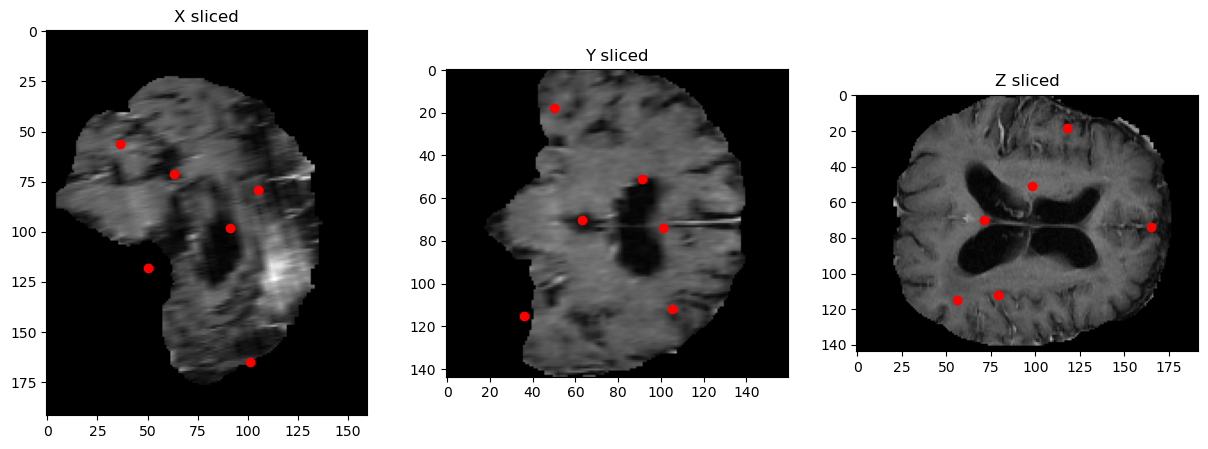

In [41]:
group = 'training'
index = 15
with h5py.File(hdf5_file, 'r') as f:
    img = f[group+'/follow/t1ce'][str(index)][:]
    landmarks = f[group+'/follow/landmarks'][str(index)][:]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img[72, :, :], cmap='gray', vmin=0, vmax=1)
    axs[0].scatter(landmarks[:, 2], landmarks[:, 1], c='r')
    axs[0].set_title('X sliced')

    axs[1].imshow(img[:, 96, :], cmap='gray', vmin=0, vmax=1)
    axs[1].scatter(landmarks[:, 2], landmarks[:, 0], c='r')
    axs[1].set_title('Y sliced')

    axs[2].imshow(img[:, :, 80], cmap='gray', vmin=0, vmax=1)
    axs[2].scatter(landmarks[:, 1], landmarks[:, 0], c='r')
    axs[2].set_title('Z sliced')


In [30]:
print(img.shape)

(144, 192, 160)
